![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 24 - Time Series Analysis</center>
### <center> Auto-regressive </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/24_TimeSeries/MainAR.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

#### Just a plot function:

In [17]:
from scipy.stats                   import gaussian_kde, norm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic  import acorr_ljungbox

def PlotResidual(En, fig):
    std     = np.std(En)
    kde     = gaussian_kde(En)
    _, pVal = acorr_ljungbox(En, [40], return_df=False)
    pVal    = pVal[-1]

    ax = fig.add_subplot(2,1,1)
    x  = np.arange(len(En))
    ax.stem(x, En, use_line_collection=True, label='$e_n$')
    ax.hlines(0, x[0], x[-1], alpha = 0.5)
    ax.set_xlim( x[0], x[-1])
    ax.set_title('$\mu_e = ' + "%1.3f" % np.mean(En) + '$, $\sigma_e = ' + "%1.3f" % std + '$')
    plt.xlabel('$n$')
    plt.legend()

    ax   = fig.add_subplot(2,2,3)
    xlim = (-3*std, 3*std)
    x    = np.linspace(xlim[0], xlim[1])
    ax.hist(En, density=True, color='c', edgecolor='k', label='Hist')
    ax.plot(x, kde(x),                                  label='KDE')
    ax.plot(x, norm.pdf(x, 0, std),                     label='$\mathcal{N}(0,\sigma^2)$')
    ax.set_xlim(xlim)
    ax.legend()
    ax.set_title('Density estimation')

    ax = fig.add_subplot(2,2,4)
    plot_acf(En, ax=ax, lags = 20, adjusted=True, label='$\hat{\\rho}_{e}[k]$')
    ax.set_title('white noise test: $p = ' + '%1.5f' % pVal + '$')
    plt.xlabel('$k$')
    plt.legend()

    plt.tight_layout()

    return fig

### Load the Lynx data:

In [18]:
dData = pd.read_csv('./Lynx.csv')
N     = len(dData)
dData

,Unnamed: 0,x
0,1,269
1,2,321
2,3,585
3,4,871
4,5,1475
...,...,...
109,110,662
110,111,1000
111,112,1590
112,113,2657


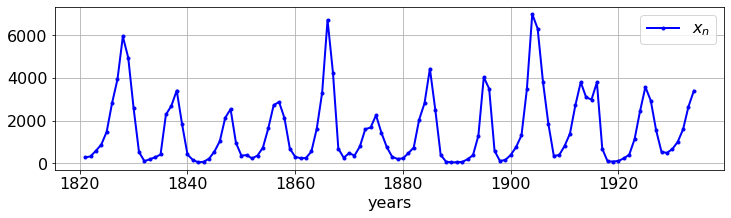

In [19]:
vTime = np.arange(1821, 1821 + N)
vXn   = dData.x.values

plt.figure(figsize=(12,3)); plt.grid(True)
plt.plot(vTime, vXn, 'b', lw=2, marker='.', label='$x_n$')
plt.xlabel('years')
plt.legend()
plt.show()

### Plot the ACF and PACF:

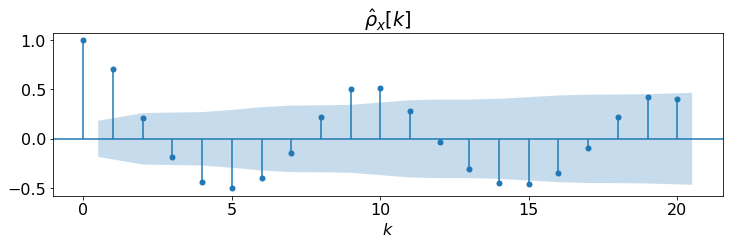

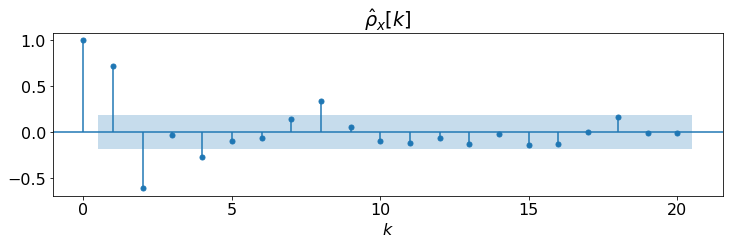

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

_, ax = plt.subplots(1, 1, figsize=(12,3))
plot_acf(vXn, lags=20, ax=ax)
plt.title('$\hat{\\rho}_x[k]$')
plt.xlabel('$k$')

_, ax = plt.subplots(1, 1, figsize=(12,3))
plot_pacf(vXn, lags=20, ax=ax)
plt.title('$\hat{\\rho}_x[k]$')
plt.xlabel('$k$')
plt.show()

### Naive estimation:
$$\hat{X}_{n}=X_{n-1}$$

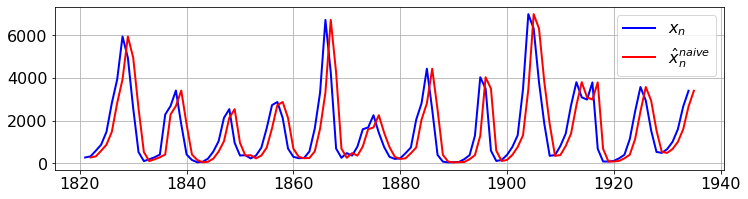

In [21]:
vNaiveX = vXn

plt.figure(figsize=(12,3)); plt.grid(True)
plt.plot(vTime,   vXn,     'b', lw=2, label='$x_n$')
plt.plot(vTime+1, vNaiveX, 'r', lw=2, label='$\hat{x}_n^{naive}$')
plt.legend()
plt.show()

### Plot error (residual) statistics:
\begin{align*}
E_{n} & =X_{n}-\hat{X}_{n}\\
 & =X_{n}-X_{n-1}
\end{align*}

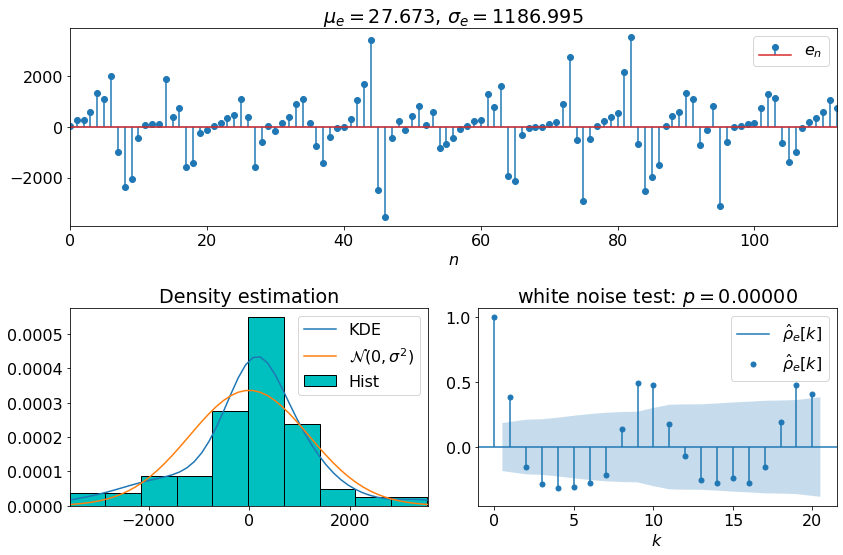

In [22]:
vEn = vXn[1:] - vNaiveX[:-1]

fig = plt.figure(figsize=(12,8))
PlotResidual(vEn, fig)
plt.show()

Since $\left\{ E_{n}\right\} _{n}$ is not a white noise process ($\hat{\rho}_{e}$
does not seem like a delta function),  
we can improve our estimation.

### AR($p$) with $p=2$

In [23]:
from statsmodels.tsa.statespace import sarimax

p      = 2
oArMdl = sarimax.SARIMAX(vXn, order=(p,0,0), trend='c').fit()
oArMdl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -935.024
Date:                Sat, 09 Jan 2021   AIC                           1878.047
Time:                        12:14:24   BIC                           1888.992
Sample:                             0   HQIC                          1882.489
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    710.1055    195.862      3.626      0.000     326.224    1093.987
ar.L1          1.1454      0.064     17.833      0.000       1.020       1.271
ar.L2         -0.6015      0.085     -7.090      0.000      -0.768      -0.435
sigma2      7.767e+05   8.09e+04      9.600      0.000    6.18e+05    9.35e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                47.66
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.81   Skew:                             0.87
Prob(H) (two-sided):                  0.07   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

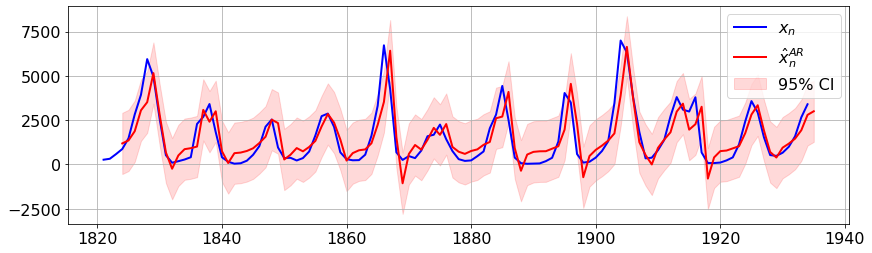

In [24]:
oPred  = oArMdl.get_prediction(p+1, N, dynamic=False)
vHatXn = oPred.predicted_mean
mCI    = oPred.conf_int(alpha = 0.05)

plt.figure(figsize=(14,4)); plt.grid(True)
plt.fill_between(vTime[p:]+1, mCI[:,0], mCI[:,1],
                 color='r', alpha=.15,   label = '95% CI')
plt.plot(vTime,       vXn,    'b', lw=2, label='$x_n$')
plt.plot(vTime[p:]+1, vHatXn, 'r', lw=2, label='$\hat{x}_n^{AR}$')
plt.legend()
plt.show()

### Plot error (residual) statistics:
\begin{align*}
E_{n} & =X_{n}-\hat{X}_{n}\\
 & =X_{n}-\left(c+a_{1}X_{n-1}+a_{2}X_{n-2}\right)
\end{align*}


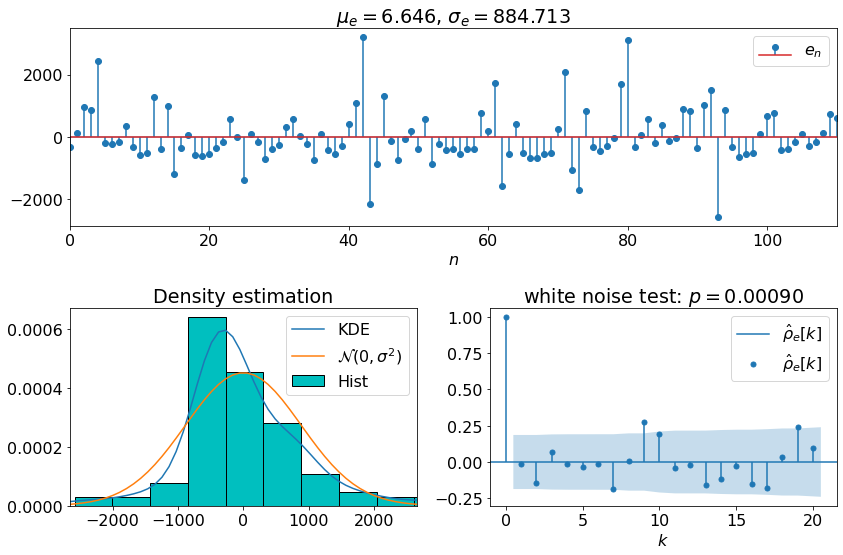

In [25]:
vEn = vXn[p+1:] - vHatXn[:-1]

fig = plt.figure(figsize=(12,8))
PlotResidual(vEn, fig)
plt.show()

### AR($p$):

In [26]:
def PlotAR(p):
    oArMdl = sarimax.SARIMAX(vXn, order=(p,0,0), trend='c').fit()
    oPred  = oArMdl.get_prediction(p+1, N, dynamic=False)
    vHatXn = oPred.predicted_mean
    mCI    = oPred.conf_int(alpha = 0.05)

    plt.figure(figsize=(12,3)); plt.grid(True)
    plt.fill_between(vTime[p:]+1, mCI[:,0], mCI[:,1],
                    color='r', alpha=.15,   label = '95% CI')
    plt.plot(vTime,       vXn,    'b', lw=2, label='$x_n$')
    plt.plot(vTime[p:]+1, vHatXn, 'r', lw=2, label='$\hat{x}_n^{AR}$')
    plt.legend()

    vEn = vXn[p+1:] - vHatXn[:-1]

    fig = plt.figure(figsize=(12,6))
    PlotResidual(vEn, fig)

In [27]:
from ipywidgets   import interact, IntSlider, Layout

pSlider = IntSlider(min=0, max=30,  step=1,  value=1,  layout=Layout(width='80%'))
interact(PlotAR, p=pSlider)
plt.tight_layout()
plt.show()

interactive(children=(IntSlider(value=1, description='p', layout=Layout(width='80%'), max=30), Output()), _dom…

<Figure size 432x288 with 0 Axes>